# Global indicator project - Phoenix, Arizona

## OSM set up
Using OpenStreetMap as a source for 
* place boundary
* complete road network
* a pedestrian 'walk/cycle' network
* public transportation infrastructure network
* calculating street network stats
* calculating intersection density for the pedestrian network


In [1]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import fiona
import pandas as pd

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

## Get place boundary

In [2]:
suffix = '_201905'

places = ['Phoenix, Arizona, USA']

In [4]:
def studyregion_buffered(address):
    G_gdf = ox.gdf_from_place(address, buffer_dist=1e4)
    return G_gdf


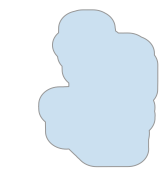

In [5]:
for address in places:
    studyregion = studyregion_buffered(address)
    ox.plot_shape(studyregion, figsize=(3,3))

## Get complete street network and pedestrain network

In [7]:
# Extract complete OSM network: "all (non-private) OSM streets and paths"

def OSM_all(address):    
    #studyregion = studyregion_buffered(address)
    #polygon = studyregion['geometry'].iloc[0]
    #W_all = ox.graph_from_polygon(polygon, network_type= 'all', retain_all = True)
    #W_all = ox.graph_from_address(address, network_type= 'all', retain_all = True)

    W_all = ox.graph_from_place(address, network_type= 'all', retain_all = True, buffer_dist=1e4)
    ox.save_graphml(W_all, filename='osm_{studyregion}_all{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../output_shp')
    W_all_proj = ox.project_graph(W_all)
    W_proj_gdfs = ox.graph_to_gdfs(W_all_proj, nodes=False, edges=True, fill_edge_geometry=True)
    
    #show network figure
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = W_proj_gdfs.plot(ax=ax)
    ax.set_title(address)
    ax.set_axis_off()
    fig.suptitle('All OSM street network', fontsize=14, fontweight='bold')
    fig.text(0.1, 0, 'note: all non-private street network')
    plt.show()



In [8]:
# Extract pedestrain OSM network
def OSM_pedestrain(address):
    #studyregion = studyregion_shape(address)
    #polygon = studyregion['geometry'].iloc[0]
    #W_walk = ox.graph_from_polygon(polygon, network_type= 'walk')
    
    #W_walk = ox.graph_from_address(address, network_type= 'walk')
    W_walk = ox.graph_from_place(address, network_type= 'walk', buffer_dist=1e4)
    ox.save_graphml(W_walk, filename='osm_{studyregion}_walk{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../output_shp')
    
    W_walk_proj = ox.project_graph(W_walk)
    W_proj_gdfs = ox.graph_to_gdfs(W_walk_proj, nodes=False, edges=True, fill_edge_geometry=True)
    
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = W_proj_gdfs.plot(ax=ax)
    ax.set_title(address)
    ax.set_axis_off()
    fig.suptitle('All OSM pedestrain network', fontsize=14, fontweight='bold')
    fig.text(0.1, 0, 'note: based on OSMnx walk network type, with the cycling exclusion')
    plt.show()




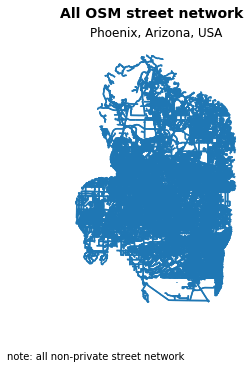

In [9]:
for address in places:
    OSM_all(address)

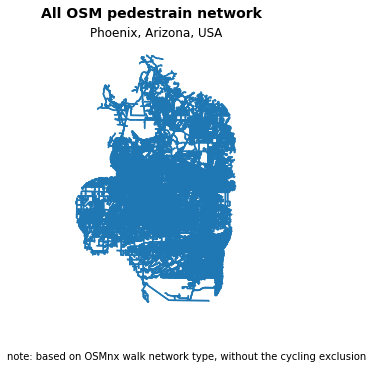

In [10]:
for address in places:
    OSM_pedestrain(address)

### pedestrain network stats
Note: may be helpful to think which stats to keep and compare accross places

In [3]:
# show some basic stats about the pedestrain network
def OSM_pedestrian_stats(address):
    #studyregion = studyregion_shape(address)
    #polygon = studyregion['geometry'].iloc[0]
    #W_walk = ox.graph_from_polygon(polygon, custom_filter= pedestrian, retain_all = True)
    W_walk = ox.graph_from_address(address, network_type= 'walk')
    W_walk_proj = ox.project_graph(W_walk)
    
    # get the sized area our network cover in square meters
    nodes_proj = ox.graph_to_gdfs(W_walk_proj, edges=False)
    graph_area_m = nodes_proj.unary_union.convex_hull.area
    
    #calculate stats and put it in a dataframe
    stats = ox.basic_stats(W_walk_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean', tolerance=15)
    #keep_stats = {k: v for k, v in stats.items() if k not in ['streets_per_node_counts', 'streets_per_node_proportion']}
    stats_df = pd.DataFrame.from_dict(stats, orient='index', columns=['pedestrain ' + (address)])
    return stats_df


In [5]:
for address in places:
    W_walk_stats = OSM_pedestrian_stats(address)
W_walk_stats

,"pedestrain Phoenix, Arizona, USA"
n,1335
m,4000
k_avg,5.99251
intersection_count,1126
streets_per_node_avg,3.08315
streets_per_node_counts,"{0: 0, 1: 209, 2: 0, 3: 609, 4: 505, 5: 12}"
streets_per_node_proportion,"{0: 0.0, 1: 0.15655430711610488, 2: 0.0, 3: 0...."
edge_length_total,202780
edge_length_avg,50.6949
street_length_total,102457


## Clean intersections

Note: this code is adopted from 'OSMNX intersection tuning.ipynb'

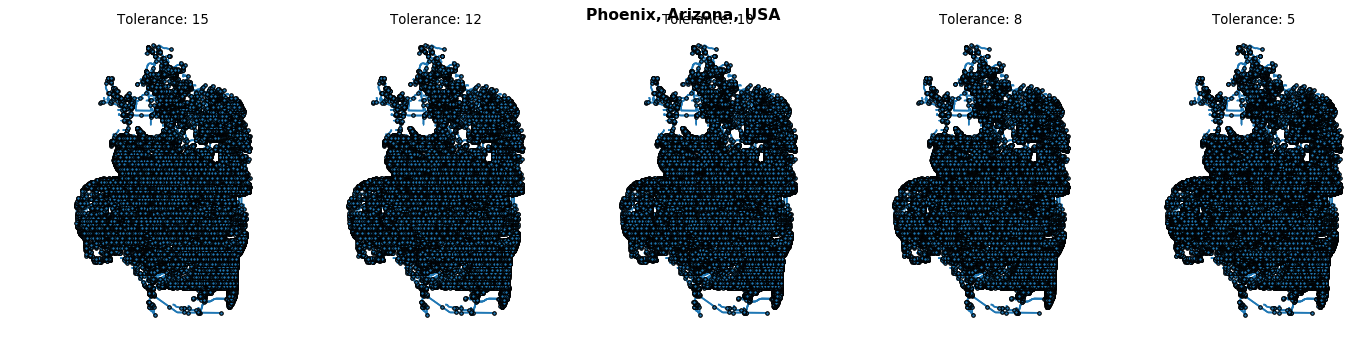

In [5]:
def OSM_clean_intersection(address):
    G = ox.graph_from_place(address, network_type= 'walk', buffer_dist=1e4)
    G_proj = ox.project_graph(G)
    G_proj_gdfs = ox.graph_to_gdfs(G_proj, nodes=False, edges=True, fill_edge_geometry=True)
    #itereate over cleaning buffer distance
    buffers = [15,12,10,8,5]
    # instantiate plot
    fig, axarr = plt.subplots(ncols=5, sharex='col', sharey='row', squeeze=False, figsize=(18,4.5), dpi=80)
    for i in range(len(buffers)):
        # clean up the intersections and extract their xy coords
        intersections = ox.clean_intersections(G_proj, tolerance=buffers[i], dead_ends=False)
        points = np.array([point.xy for point in intersections])
        # plot the cleaned-up intersections
        G_proj_gdfs.plot(ax = axarr[0][i])
        axarr[0][i].scatter(x=points[:,0], y=points[:,1], s = 10, zorder=2, color=None, edgecolors='#000000')
        axarr[0][i].set_title("Tolerance: {}".format(buffers[i]))
        axarr[0][i].set_aspect(1)
        axarr[0][i].set_axis_off()
        # axarr[0][i].add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2))
    plt.suptitle(address, fontsize=14, fontweight='bold')    
    plt.tight_layout()
    plt.show()
    return intersections

for address in places:
    OSM_clean_intersection(address)

Idea (from Carl): Could be interesting to overlay modified tolerances with some kind of image difference overlay relative to original (e.g. colourize where nodes have been added or subtracted)

## Public transportation

Not sure how it compares to the reality.

The public_transport key denotes stop positions and platforms of public transport. Stop position are placed as node on the street. Platforms are placed next to the street. Both are members of the relation stop_area and route relations. https://wiki.openstreetmap.org/wiki/Key:public_transport  
https://wiki.openstreetmap.org/wiki/Public_transport  

Test the queries: https://overpass-turbo.eu/  
OSmnx network type: https://github.com/gboeing/osmnx/blob/eb39dff4aaf726d33b6b7aa9f71c50f3e9b9f012/osmnx/core.py#L560  
OSM tags: https://wiki.openstreetmap.org/wiki/Tags

### Tag: Public Transport

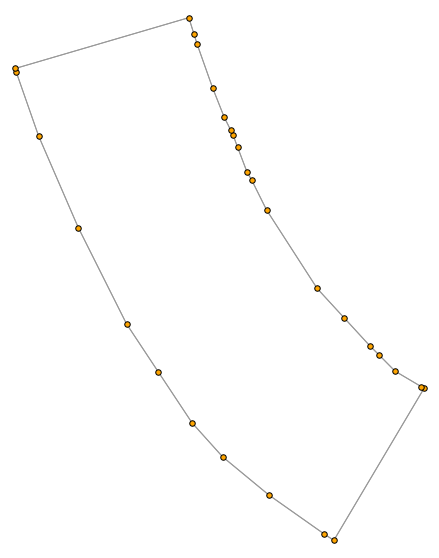

In [24]:
T = ox.graph_from_place('Phoenix, Arizona, USA',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='none', infrastructure='way["public_transport"]')
T_proj = ox.project_graph(T)

fig, ax = ox.plot_graph(T_proj, fig_height=10, node_color='orange', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

### Tag: Bus stop

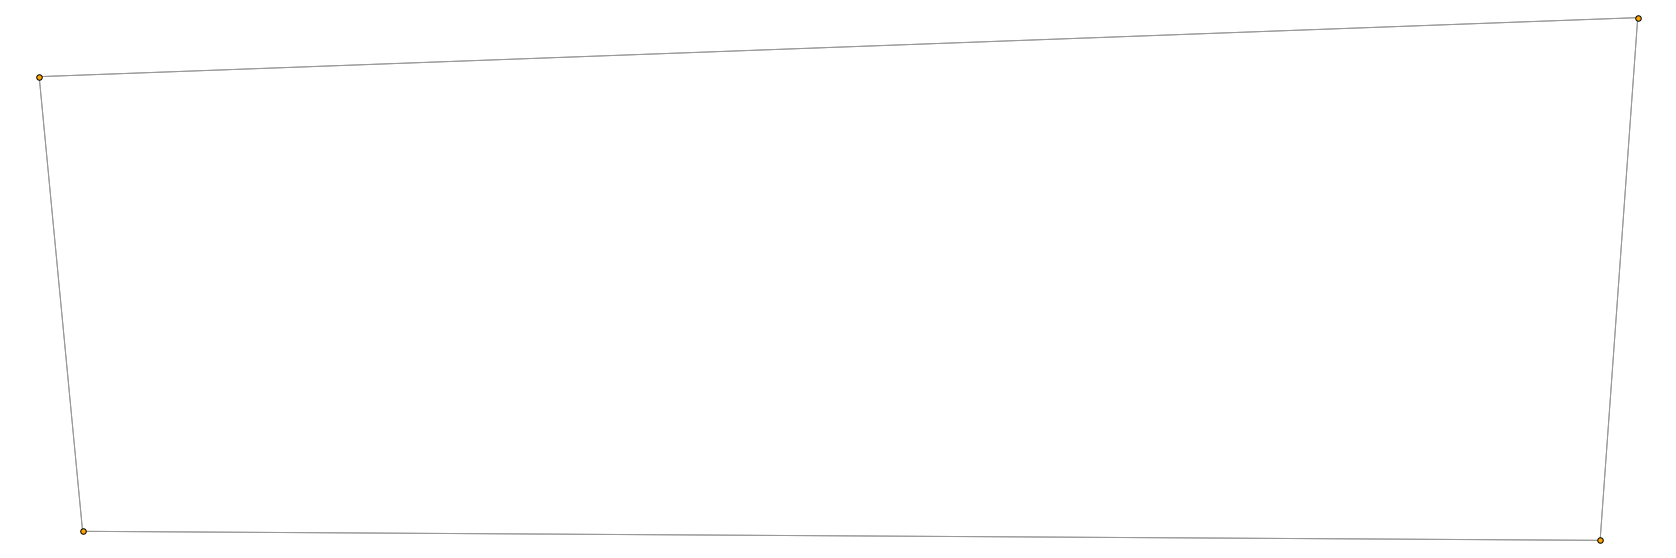

In [19]:
B = ox.graph_from_place('Phoenix, Arizona, USA',
                        retain_all=False, network_type='none', infrastructure='way["highway"~"bus_stop"]')
B_proj = ox.project_graph(B)

fig, ax = ox.plot_graph(B_proj, fig_height=10, node_color='orange', node_size=30, 
                        node_zorder=2, node_edgecolor='k')


### Tag: Cycle lanes

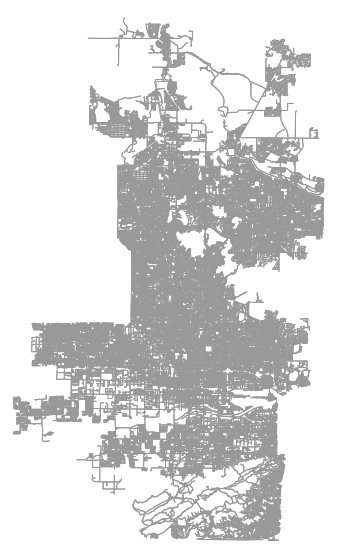

In [8]:
B = ox.graph_from_place('Phoenix, Arizona, USA',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='bike')
B_proj = ox.project_graph(B)

fig, ax = ox.plot_graph(B_proj, fig_height=10, node_size=0)